In [1]:
import sys
sys.path.append('/cluster/sj1')

In [2]:
%load_ext autoreload
%autoreload 2

import torch
import pyro
import numpy as np
from scipy.stats import kendalltau
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from bb_opt.src.bayesian_opt import (
    optimize,
    get_model_bnn,
    train_model_bnn,
    partial_train_model_bnn,
    train,
    bnn_predict
)
from bb_opt.src.utils import get_path, save_pyro_model, load_pyro_model
from gpu_utils.utils import gpu_init
from tqdm import tnrange

gpu_id = gpu_init()
print(f"Running on GPU {gpu_id}")
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

%matplotlib inline

Running on GPU 1


In [3]:
def jointplot(predicted, true, title: str=""):
    if isinstance(predicted, torch.Tensor):
        predicted = predicted.detach().cpu().numpy()

    if isinstance(true, torch.Tensor):
        true = true.detach().cpu().numpy()
        
    ax = sns.jointplot(predicted, true, s=3, alpha=0.5)
    ax.set_axis_labels('Predicted', 'True')
    ax.ax_marg_x.set_title(title)
    return ax

In [4]:
n_train = 1000

project = "dna_binding"
dataset = "crx_ref_r1"
batch_size = 1
retrain_every = 1000000
partial_steps = 20

root = "/cluster/sj1/bb_opt/"
data_dir = get_path(root, "data", project, dataset)
inputs = np.load(get_path(data_dir, "inputs.npy"))
labels = np.load(get_path(data_dir, "labels.npy"))
train_inputs, test_inputs, train_labels, test_labels = train_test_split(inputs, labels, train_size=n_train, random_state=521)
train_inputs, val_inputs, train_labels, val_labels = train_test_split(train_inputs, train_labels, train_size=0.9, random_state=521)

top_k_percent = 1

/cluster/sj1/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [5]:
train_label_mean = train_labels.mean()
train_label_std = train_labels.std()

train_labels = (train_labels - train_label_mean) / train_label_std
val_labels = (val_labels - train_label_mean) / train_label_std
test_labels = (test_labels - train_label_mean) / train_label_std

In [6]:
n_samples = 10
prior_mean = 0
prior_std = 1

bnn_model, guide = get_model_bnn(inputs.shape[1], batch_size, prior_mean, prior_std, device=device)
optimizer = pyro.optim.Adam({})

pyro.clear_param_store()

svi = pyro.infer.SVI(bnn_model, guide, optimizer, pyro.infer.Trace_ELBO(n_samples))

to_torch = lambda array: torch.tensor(array, dtype=torch.float32, device=device)
train_inputs, val_inputs, test_inputs, train_labels, val_labels, test_labels = list(map(to_torch, [train_inputs, val_inputs, test_inputs, train_labels, val_labels, test_labels]))

In [7]:
train_losses = []
val_losses = []

train_corrs = []
val_corrs = []

In [8]:
model_path = "crx_100_starter_sid"

progress = tnrange(1000)
for i in progress:
    print(i)
    train_losses += train(svi, 5, train_inputs, train_labels, verbose=False)

    preds = bnn_predict(guide, train_inputs, n_samples=50).mean(axis=0)
    train_corrs.append(kendalltau(preds, train_labels)[0])

#     if n_inputs == 1:
#         mses.append((preds - train_labels.item()) ** 2)

    preds = bnn_predict(guide, val_inputs, n_samples=50).mean(axis=0)
    val_corr = kendalltau(preds, val_labels)[0]

    if val_corr > max(val_corrs, default=-float("inf")):
        save_pyro_model(model_path, optimizer)

    val_corrs.append(val_corr)
    progress.set_description(f"Corr: {val_corr:.3f}")


#     _, sorted_idx = train_labels.sort(descending=True)
#     n_10_percent = int(len(train_labels) * .1)

#     preds = bnn_predict(guide, train_inputs[sorted_idx][:n_10_percent], n_samples=50).mean(axis=0)
#     best_train_corrs.append(kendalltau(preds, train_labels[sorted_idx][:n_10_percent])[0])

#     _, sorted_idx = test_labels.sort(descending=True)
#     n_10_percent = int(len(test_labels) * .1)

#     preds = bnn_predict(guide, test_inputs[sorted_idx][:n_10_percent], n_samples=50).mean(axis=0)
#     best_test_corrs.append(kendalltau(preds, test_labels[sorted_idx][:n_10_percent])[0])

A Jupyter Widget

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [18]:
#model, guide = bnn_model()
#model_dir = '/cluster/sj1/bb_opt/models'
model_dir = '.'
model_prefix = 'crx_100_starter'
pyro.get_param_store().load(model_dir + '/' + model_prefix + '.params')
optimizer = pyro.optim.Adam({})
optimizer.load(model_dir+'/'+model_prefix+'.opt')

/cluster/sj1/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


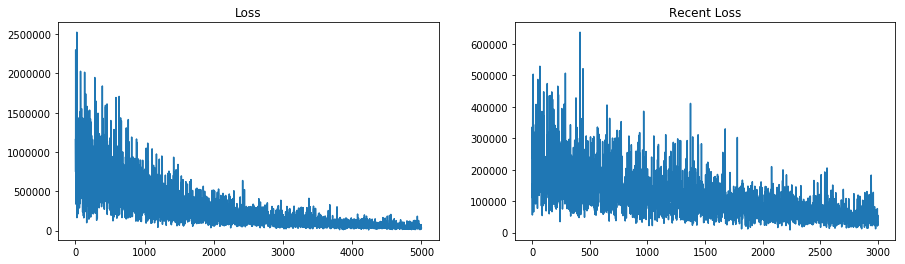

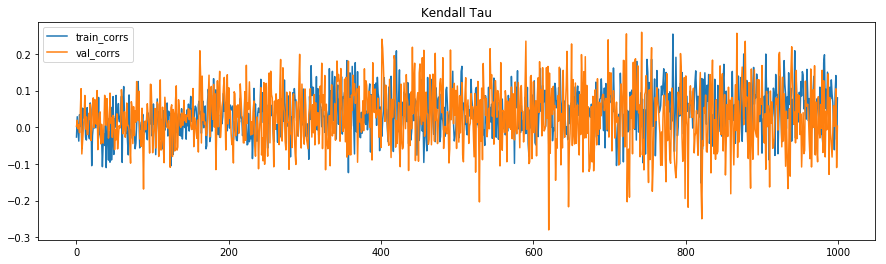

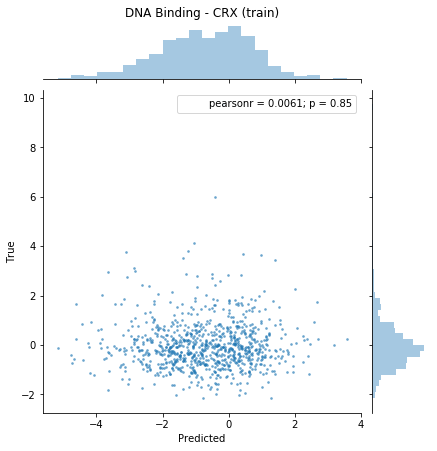

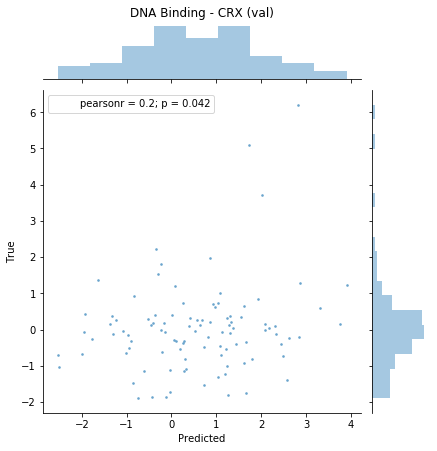

In [9]:
plt.figure(figsize=(15, 4))

plt.subplot(121)
plt.plot(train_losses)
plt.title("Loss")

plt.subplot(122)
plt.plot(train_losses[-3000:])
plt.title("Recent Loss")

plt.figure(figsize=(15, 4))

# plt.subplot(121)
# plt.plot(mses)
# plt.title("MSE")

# plt.subplot(122)
plt.plot(train_corrs, label="train_corrs")
plt.plot(val_corrs, label="val_corrs")
plt.legend()
plt.title("Kendall Tau");
# plt.plot(pd.Series(losses[-3000:]).rolling(window=100).median());

title = "DNA Binding - CRX"
train_title = title + " (train)"
val_title = title + " (val)"

if n_train > 1:
    preds = bnn_predict(guide, train_inputs, n_samples=100).mean(axis=0)
    jointplot(preds, train_labels, train_title)

preds = bnn_predict(guide, val_inputs, n_samples=100).mean(axis=0)
jointplot(preds, val_labels, val_title);

In [ ]:
plt.figure(figsize=(15, 4))

plt.subplot(121)
plt.plot(losses)
plt.title("Loss")

plt.subplot(122)
plt.plot(losses[-3000:])
plt.title("Recent Loss")

plt.figure(figsize=(15, 4))

plt.subplot(121)
plt.plot(mses)
plt.title("MSE")

plt.subplot(122)
plt.plot(train_corrs, label="train_corrs")
plt.plot(test_corrs, label="test_corrs")
plt.legend()
plt.title("Kendall Tau");
# plt.plot(pd.Series(losses[-3000:]).rolling(window=100).median());

title = "DNA Binding - CRX"
train_title = title + " (train)"
test_title = title + " (test)"

if n_inputs > 1:
    preds = bnn_predict(guide, train_inputs, n_samples=50).mean(axis=0)
    jointplot([preds], train_labels, train_title)

preds = bnn_predict(guide, test_inputs, n_samples=50).mean(axis=0)
jointplot(preds, test_labels, test_title);

In [ ]:
save_pyro_model(model_path, optimizer)

In [51]:
from bb_opt.src.hsic import dimwise_mixrq_kernels, dimwise_mixrbf_kernels, total_hsic

In [22]:
n_preds = 50
with torch.no_grad():
    preds = [torch.unsqueeze(guide()(train_inputs).squeeze(), 0) for _ in range(n_preds)]
preds = torch.cat(preds)

In [23]:
preds.shape

torch.Size([50, 900])

In [24]:
preds.max(), preds.min()

(tensor(209.1691, device='cuda:0'), tensor(-173.8211, device='cuda:0'))

In [25]:
train_labels.max(), train_labels.min()

(tensor(9.7301, device='cuda:0'), tensor(-2.1442, device='cuda:0'))

In [52]:
k = dimwise_mixrq_kernels(preds)
k.shape, k.max(), k.min()

(torch.Size([50, 50, 900]), tensor(1., device='cuda:0'), tensor(1.00000e-02 *
        1.7212, device='cuda:0'))

In [53]:
total_hsic(k, logspace=False)

t1: tensor(1.00000e-02 *
       2.0000, device='cuda:0')
t3: tensor(nan., device='cuda:0')


tensor(nan., device='cuda:0')

In [ ]:
k = dimwise_mixrbf_kernels(preds.to(torch.float64))
k.shape, k.dtype

In [ ]:
k.max(), k.min()

In [ ]:
total_hsic(k)

In [ ]:
from IPython.display import Audio, display


class InvisibleAudio(Audio):
    def _repr_html_(self):
        audio = super()._repr_html_()
        audio = audio.replace('<audio', f'<audio onended="this.parentNode.removeChild(this)"')
        return f'<div style="display:none">{audio}</div>'

In [ ]:
from time import time, sleep
from IPython import get_ipython
from IPython.core.magic import register_line_cell_magic
from IPython.display import Audio, display
from IPython.core.display import HTML

from IPython.core import magic_arguments
from IPython.core.magic import line_cell_magic, Magics, magics_class
 
@magics_class
class NotificationMagics(Magics):
    @line_cell_magic
    @magic_arguments.magic_arguments()
    @magic_arguments.argument('--url', '-u',
          help='URL of sound to play
    )
    def notify(self, line, cell=None, url: str='http://www.soundjay.com/button/beep-07.wav'):
        if cell is None:
            ret = self.shell.ex(line)
        else:
            ret = self.shell.ex(cell)

        audio = InvisibleAudio(url=url, autoplay=True)
        display(audio)

        return ret

In [ ]:
ip = get_ipython()
ip.register_magics(NotificationMagics)

In [ ]:
%notify